## Final Report



### Voice anti spoofing : 
We aim to differentiate meticulously crafted deepfake audio. 여기 pipeline 이미지 첨부

### Description of Dataset
Our dataset comprises real and fake audio samples. The real audio dataset consists of 13,100 short audio clips from the LJ Speech dataset, featuring a single speaker. The fake audio dataset, WaveFake, encompasses 104,885 generated audio clips. These fake audio clips were produced using various architectures, including MelGAN, Parallel WaveGAN, Multi-band MelGAN, Full-band MelGAN, HiFi-GAN, and WaveGlow. We selected WaveFake due to its diversity in generated audio types, which we anticipate will aid in model generalization.

### Mount Google Drive for Demonstration
We uploaded mini dataset(https://drive.google.com/drive/folders/1sYOw11JKgt2P0HGpmYR28JlC8n1TIQHd?usp=drive_link) for demonstration as our full dataset is about 30G. Please note that our full dataset was too big to be uploaded in google drive. 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google'

In [106]:
import json
import warnings
from pathlib import Path
import os
import time
import random

import torch
from torch.utils.data import ConcatDataset, DataLoader, Dataset
import torch.nn as nn
from torch.nn import functional as F
import torchaudio.functional as audio_F
from torchaudio.functional import apply_codec
from torchaudio.transforms import AmplitudeToDB, Spectrogram
import numpy as np
import functools
import torchaudio


import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import sklearn.metrics as skm
from scipy.interpolate import interp1d
from scipy.optimize import brentq

warnings.filterwarnings("ignore")

### DataLoader

#### Audio Processing & Split
**LFCC (Linear Frequency Cepstral Coefficients)**

We used LFCC feature extraction, a technique commonly used in speech signal processing for audio processing. LFCC features capture the spectral characteristics of audio signals.

1) Spectrograqm Computing : Transform audio waveform to spectrogram
2) Linear filtering : Highlight important frequency components
2) Logarithmic transformation : Refine the representation
3) Discrete Cosine Transform (DCT): Extract LFCC coefficients, which encapsulate the spectral characteristics of the audio

**Train/Validation split**

We split the dataset in the ratio of 80:20.

In [107]:

SOX_SILENCE = [
    # trim all silence that is longer than 0.2s and louder than 1% volume (relative to the file)
    # from beginning and middle/end
    ["silence", "1", "0.2", "1%", "-1", "0.2", "1%"],
]

def _create_lin_filter(sample_rate, n_fft, n_filter, f_min=0.0, f_max=None, dtype=torch.float32):
    
    if f_max is None:
        f_max = float(sample_rate) / 2

    n_filter = int(n_filter)
    weights = torch.zeros((n_filter, int(1 + n_fft // 2)), dtype=dtype)
    fftfreqs = torch.linspace(0, float(sample_rate) / 2, int(1 + n_fft // 2))
    linear_f = torch.linspace(f_min, f_max, n_filter + 2)
    fdiff = torch.diff(linear_f)
    ramps = linear_f[..., None] - fftfreqs[..., None, :]

    for i in range(n_filter):
        lower = -ramps[i] / fdiff[i]
        upper = ramps[i + 2] / fdiff[i + 1]
        weights[i] = torch.maximum(torch.zeros(1), torch.minimum(lower, upper))

    return weights

class LFCC(torch.nn.Module):
    
    def __init__(self, sample_rate = 16000, n_lin = 128, n_lfcc = 40, f_min = 0.0, f_max = None, dct_type = 2, norm = "ortho", log_lf = False, speckwargs = None):
        super().__init__()

        self.sample_rate = sample_rate
        self.n_lin = n_lin
        self.n_lfcc = n_lfcc
        self.f_min = f_min
        self.f_max = f_max
        self.dct_type = dct_type
        self.norm = norm
        self.top_db = 80.0
        self.amplitude_to_DB = AmplitudeToDB("power", self.top_db)

        if speckwargs is not None:
            self.Spectrogram = Spectrogram(**speckwargs)
        else:
            self.Spectrogram = Spectrogram()

        filter_mat = _create_lin_filter(sample_rate=self.sample_rate, n_fft=self.Spectrogram.n_fft, n_filter=self.n_lin, f_min=self.f_min, f_max=self.f_max).T
        
        self.register_buffer("filter_mat", filter_mat)

        dct_mat = audio_F.create_dct(n_lfcc, self.n_lin, self.norm)
        self.register_buffer("dct_mat", dct_mat)
        self.log_lf = log_lf

    def forward(self, waveform: torch.Tensor):
        
        specgram = self.Spectrogram(waveform)
        shape = specgram.size()
        specgram = specgram.reshape(-1, shape[-2], shape[-1])
        specgram = torch.matmul(specgram.transpose(1, 2), self.filter_mat)
        specgram = specgram.transpose(1, 2)
        specgram = specgram.reshape(shape[:-2] + specgram.shape[-2:])

        if self.log_lf:
            log_offset = 1e-6
            specgram = torch.log(specgram + log_offset)
        else:
            specgram = self.amplitude_to_DB(specgram)

        lfcc = torch.matmul(specgram.transpose(-2, -1), self.dct_mat)

        return lfcc.transpose(-2, -1)
    
class AudioDataset(Dataset):

    def __init__(self, directory_or_path_list, sample_rate = 16_000, amount = None, normalize = True, trim = True):
        super().__init__()

        self.trim = trim
        self.sample_rate = sample_rate
        self.normalize = normalize

        if isinstance(directory_or_path_list, list):
            paths = directory_or_path_list
        elif isinstance(directory_or_path_list, Path) or isinstance(directory_or_path_list, str):
            directory = Path(directory_or_path_list)
            paths = find_wav_files(directory)
        else:
            raise TypeError(
                f"Supplied unsupported type for argument directory_or_path_list {type(directory_or_path_list)}!"
            )

        if amount is not None:
            paths = paths[:amount]

        self._paths = paths

    def __getitem__(self, index):
        path = self._paths[index]
        waveform, sample_rate = torchaudio.load(path, normalize=self.normalize)

        if sample_rate != self.sample_rate:
            waveform, sample_rate = torchaudio.sox_effects.apply_effects_file(path, [["rate", f"{self.sample_rate}"]], normalize=self.normalize)

        if self.trim:
            waveform_trimmed,sample_rate_trimmed= torchaudio.sox_effects.apply_effects_tensor(waveform, sample_rate, SOX_SILENCE)

            if waveform_trimmed.size()[1] > 0:
                waveform = waveform_trimmed
                sample_rate = sample_rate_trimmed

        audio_path = str(path)

        return waveform, sample_rate, str(audio_path)

    def __len__(self):
        return len(self._paths)


class PadDataset(Dataset):
    def __init__(self, dataset, cut = 64600, label=None):
        self.dataset = dataset
        self.cut = cut 
        self.label = label

    def __getitem__(self, index):
        waveform, sample_rate, audio_path = self.dataset[index]
        waveform = waveform.squeeze(0)
        waveform_len = waveform.shape[0]
        if waveform_len >= self.cut:
            if self.label is None:
                return waveform[: self.cut], sample_rate, str(audio_path)
            else:
                return waveform[: self.cut], sample_rate, str(audio_path), self.label
        # need to pad
        num_repeats = int(self.cut / waveform_len) + 1
        padded_waveform = torch.tile(waveform, (1, num_repeats))[:, : self.cut][0]

        if self.label is None:
            return padded_waveform, sample_rate, str(audio_path)
        else:
            return padded_waveform, sample_rate, str(audio_path), self.label

    def __len__(self):
        return len(self.dataset)


class TransformDataset(Dataset):
    
    def __init__(self, dataset, transformation, needs_sample_rate = False, transform_kwargs = {}):
        super().__init__()
        self._dataset = dataset

        self._transform_constructor = transformation
        self._needs_sample_rate = needs_sample_rate
        self._transform_kwargs = transform_kwargs

        self._transform = None

    def __len__(self):
        return len(self._dataset)

    def __getitem__(self, index):
        waveform, sample_rate, audio_path, label = self._dataset[index]

        if self._transform is None:
            if self._needs_sample_rate:
                self._transform = self._transform_constructor(
                    sample_rate, **self._transform_kwargs
                )
            else:
                self._transform = self._transform_constructor(**self._transform_kwargs)

        return self._transform(waveform), sample_rate, str(audio_path), label


class DoubleDeltaTransform(torch.nn.Module):

    def __init__(self, win_length = 5, mode = "replicate"):
        super().__init__()
        self.win_length = win_length
        self.mode = mode
        self._delta = torchaudio.transforms.ComputeDeltas(win_length=self.win_length, mode=self.mode)

    def forward(self, X):
        
        delta = self._delta(X)
        double_delta = self._delta(delta)

        return torch.hstack((X, delta, double_delta))



def _build_preprocessing(directory_or_audiodataset, transform, audiokwargs = {}, transformkwargs = {}):
    
    if isinstance(directory_or_audiodataset, AudioDataset) or isinstance(
        directory_or_audiodataset, PadDataset
    ):
        return TransformDataset(
            dataset=directory_or_audiodataset,
            transformation=transform,
            needs_sample_rate=True,
            transform_kwargs=transformkwargs,
        )
    elif isinstance(directory_or_audiodataset, str) or isinstance(
        directory_or_audiodataset, Path
    ):
        return TransformDataset(
            dataset=AudioDataset(directory=directory_or_audiodataset, **audiokwargs),
            transformation=transform,
            needs_sample_rate=True,
            transform_kwargs=transformkwargs,
        )
    else:
        raise TypeError("Unsupported type for directory_or_audiodataset!")

lfcc = functools.partial(_build_preprocessing, transform=LFCC)


def double_delta(dataset, delta_kwargs = {}):
    return TransformDataset(
        dataset=dataset,
        transformation=DoubleDeltaTransform,
        transform_kwargs=delta_kwargs,
    )


def load_directory_split_train_test(path, feature_fn, feature_kwargs, test_size, use_double_delta = True, pad = False, label = None):
    
    paths = find_wav_files(path)

    test_size = int(test_size * len(paths))

    train_paths = paths[:-test_size]
    test_paths = paths[-test_size:]

    print(f"Loading data from {path}...!")

    train_dataset = AudioDataset(train_paths)
    test_dataset = AudioDataset(test_paths)
    if pad:
        train_dataset = PadDataset(train_dataset, label=label)
        test_dataset = PadDataset(test_dataset, label=label)

    if feature_fn is None:
        return train_dataset, test_dataset

    dataset_train = feature_fn(
        directory_or_audiodataset=train_dataset,
        transformkwargs=feature_kwargs,
    )

    dataset_test = feature_fn(
        directory_or_audiodataset=test_dataset,
        transformkwargs=feature_kwargs,
    )
    if use_double_delta:
        dataset_train = double_delta(dataset_train)
        dataset_test = double_delta(dataset_test)

    return dataset_train, dataset_test


In [108]:

FEATURE_CLASSNAMES = ("lfcc")
MODEL_CLASSNAMES = ("SimpleLSTM")
KWARGS_MAP = {
    "SimpleLSTM": {
        "lfcc": {"feat_dim": 40, "time_dim": 972, "mid_dim": 30, "out_dim": 1}
    }
}

## Model

In [109]:

class SimpleLSTM(nn.Module):
    def __init__(self, feat_dim, time_dim, mid_dim, out_dim, **kwargs):
        super(SimpleLSTM, self).__init__()
        self.lstm = nn.LSTM(
            input_size=feat_dim,
            hidden_size=mid_dim,
            num_layers=2,
            bidirectional=True,
            batch_first=True,
            dropout=0.01,
        )
        self.conv = nn.Conv1d(in_channels=mid_dim * 2, out_channels=10, kernel_size=1)
        self.fc = nn.Linear(in_features=time_dim * 10, out_features=out_dim)

    def forward(self, x):
        
        B = x.size(0)
        x = x.permute(0, 2, 1)  # (batch_size, time_dim, feat_dim)
        lstm_out, _ = self.lstm(x)  # (B, T, C=mid_dim * 2)
        feat = lstm_out.permute(0, 2, 1)  # (B, C=mid_dim * 2, T)
        feat = self.conv(feat)  # (B, C, T)
        feat = F.relu(feat)  # (B, C, T)
        feat = feat.reshape(B, -1)  # (B, C*T)
        out = self.fc(feat)  # (B, out_dim)

        return out

### Utils

In [110]:

def find_wav_files(path_to_dir):
    
    paths = list(sorted(Path(path_to_dir).glob("**/*.wav")))

    if len(paths) == 0:
        return None

    return paths


def set_seed_all(seed = 0):
    
    if not isinstance(seed, int):
        seed = 0

    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True

    os.environ["PYTHONHASHSEED"] = str(seed)
    return None


def set_benchmark_mode():
    if torch.cuda.is_available():
        torch.backends.cudnn.benchmark = True
        torch.backends.cudnn.deterministic = False
    return None


def save_checkpoint(epoch, model, optimizer, model_kwargs, filename):
    state = {
        "epoch": epoch,
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
        "model_kwargs": model_kwargs,
    }
    time.sleep(3)
    torch.save(state, filename)


def save_pred(y_true, y_pred, filename):
    pred_to_save = {
        "y_true": np.squeeze(y_true).tolist(),
        "y_pred": np.squeeze(y_pred).tolist(),
    }
    with filename.open(mode="w") as f:
        json.dump(pred_to_save, f)
        f.close()
    return None


def set_learning_rate(learning_rate, optimizer):
    for param_group in optimizer.param_groups:
        param_group["lr"] = learning_rate
    return None


### Metric

In [111]:
def alt_compute_eer(y_true, y_pred):
    
    fpr, tpr, thresholds = skm.roc_curve(y_true, y_pred, pos_label=1)
    eer = brentq(lambda x: 1.0 - x - interp1d(fpr, tpr)(x), 0.0, 1.0)
    return eer


### Trainer

In [131]:
class Trainer(object):
    
    def __init__(self, epochs, batch_size, device, lr = 1e-3, optimizer_fn = torch.optim.Adam, optimizer_kwargs = {}):
        self.epochs = int(epochs)
        self.batch_size = int(batch_size)
        self.device = device
        self.lr = lr
        self.optimizer_fn = optimizer_fn
        self.optimizer_kwargs = optimizer_kwargs
        self.optimizer_kwargs["lr"] = self.lr

class ModelTrainer(Trainer):

    def train(self, model, dataset_train, dataset_val, save_dir = None, pos_weight = None, checkpoint = None):
        if save_dir:
            save_dir: Path = Path(save_dir)
            if not save_dir.exists():
                save_dir.mkdir(parents=True)

        train_loader = DataLoader(dataset_train, batch_size=self.batch_size, shuffle=True, drop_last=False)
        val_loader = DataLoader(dataset_val, batch_size=self.batch_size,drop_last=False)

        criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
        optim = self.optimizer_fn(model.parameters(), **self.optimizer_kwargs)
        start_epoch = 0

        if checkpoint is not None:
            model.load_state_dict(checkpoint["state_dict"])
            optim.load_state_dict(checkpoint["optimizer"])
            start_epoch = checkpoint["epoch"] + 1
            print(f"Loaded checkpoint from epoch {start_epoch - 1}")

        set_learning_rate(self.lr, optim)

        train_losses = []
        val_losses = []
        train_accs = []
        val_accs = []

        best_acc = 0
        for epoch in range(start_epoch, self.epochs):
            # train
            model.train()
            total_loss = 0
            num_correct = 0.0
            num_total = 0.0

            for _, (batch_x, _, _, batch_y) in enumerate(train_loader):
                
                curr_batch_size = batch_x.size(0)
                num_total += curr_batch_size
                batch_x = batch_x.to(self.device)
                batch_y = batch_y.unsqueeze(1).type(torch.float32).to(self.device)
                batch_out = model(batch_x)  # (B, 1)
                batch_loss = criterion(batch_out, batch_y)  # (1, )
                batch_pred = (torch.sigmoid(batch_out) + 0.5).int()
                num_correct += (batch_pred == batch_y.int()).sum(dim=0).item()
                total_loss += batch_loss.item() * curr_batch_size
                optim.zero_grad()  # reset gradient
                batch_loss.backward()  # compute gradient
                optim.step()  # update params

            total_loss /= num_total
            train_acc = (num_correct / num_total) * 100
            train_losses.append(total_loss)
            train_accs.append(train_acc)

            # validation
            model.eval()
            num_correct = 0.0
            num_total = 0.0
            val_loss = 0.0

            for batch_x, _, _, batch_y in val_loader:
                curr_batch_size = batch_x.size(0)
                num_total += curr_batch_size
                batch_x = batch_x.to(self.device)
                batch_y = batch_y.unsqueeze(1).type(torch.float32).to(self.device)
                batch_out = model(batch_x)
                batch_loss = criterion(batch_out, batch_y)
                batch_pred = (torch.sigmoid(batch_out) + 0.5).int()
                num_correct += (batch_pred == batch_y.int()).sum(dim=0).item()
                val_loss += batch_loss.item() * curr_batch_size

            val_loss /= num_total
            val_acc = (num_correct / num_total) * 100
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            
            print(f"[{epoch:03d}]: loss: {round(total_loss, 4)} - train acc: {round(train_acc, 2)} - val acc: {round(val_acc, 2)}")

            if val_acc > best_acc:
                best_acc = val_acc
                print(f"Best Validation Accuracy: {round(best_acc, 3)}")

                if save_dir:
                    save_path = save_dir / "best.pt"
                    save_checkpoint(
                        epoch=epoch,
                        model=model,
                        optimizer=optim,
                        model_kwargs=self.__dict__,
                        filename=save_path,
                    )
                    print(f"Best Model Saved: {save_path}")

        # Plotting train and validation curves
        epochs = range(start_epoch, self.epochs)
        plt.figure(figsize=(12, 6))
        plt.plot(epochs, train_losses, label='Train Loss')
        plt.plot(epochs, val_losses, label='Validation Loss')
        plt.title('Training and Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

        plt.figure(figsize=(12, 6))
        plt.plot(epochs, train_accs, label='Train Accuracy')
        plt.plot(epochs, val_accs, label='Validation Accuracy')
        plt.title('Training and Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy (%)')
        plt.legend()
        plt.show()


    def eval(self, model, dataset_test, save_dir = None,  checkpoint = None):
        
        if save_dir:
            save_dir: Path = Path(save_dir)
            if not save_dir.exists():
                save_dir.mkdir(parents=True)

        test_loader = DataLoader(dataset_test,batch_size=self.batch_size, drop_last=False)

        if checkpoint is not None:
            model.load_state_dict(checkpoint["state_dict"])
            start_epoch = checkpoint["epoch"] + 1
            print(f"Loaded checkpoint from epoch {start_epoch - 1}")

        
        model.eval()
        num_correct = 0.0
        num_total = 0.0
        
        y_true = []
        y_pred = []

        for batch_x, _, _, batch_y in test_loader:
            curr_batch_size = batch_x.size(0)
            num_total += curr_batch_size
            batch_x = batch_x.to(self.device)
            batch_y = batch_y.unsqueeze(1).type(torch.float32).to(self.device)
            y_true.append(batch_y.clone().detach().int().cpu())
            batch_out = model(batch_x)
            batch_pred = (torch.sigmoid(batch_out) + 0.5).int()
            y_pred.append(batch_pred.clone().detach().cpu())
            num_correct += (batch_pred == batch_y.int()).sum(dim=0).item()

        test_acc = (num_correct / num_total) * 100
        y_true: np.ndarray = torch.cat(y_true, dim=0).numpy()
        y_pred: np.ndarray = torch.cat(y_pred, dim=0).numpy()
        test_eer = alt_compute_eer(y_true, y_pred)

        print(f"test acc: {round(test_acc, 2)} - test eer : {round(test_eer, 4)}")

        if save_dir:
            save_path = save_dir / "best_pred.json"
            save_pred(y_true, y_pred, save_path)
            print(f"Prediction Saved: {save_path}")

    def eval_one(self, model, dataset_test, checkpoint = None):

        test_loader = DataLoader(dataset_test, batch_size=self.batch_size, drop_last=False)

        if checkpoint is not None:
            model.load_state_dict(checkpoint["state_dict"])
            start_epoch = checkpoint["epoch"] + 1
            print(f"Loaded checkpoint from epoch {start_epoch - 1}")

        model.eval()

        for batch_x, _, _, batch_y in test_loader:
            batch_x = batch_x.to(self.device)
            batch_out = model(batch_x)
            batch_pred = (torch.sigmoid(batch_out))
            
            probability_of_being_fake = 1 - batch_pred.item()
            print('Probability of being Fake audio : ', probability_of_being_fake)

            if probability_of_being_fake > 0.5:
              image_path = '/home/seonghak/MIE1517-Project/assets/fake.png'
            else:
              image_path = '/home/seonghak/MIE1517-Project/assets/real.png'

        img = mpimg.imread(image_path)
        plt.imshow(img)
        plt.axis('off')  
        if probability_of_being_fake > 0.5:
            plt.title('IT IS SPOOF!!!')
        else:
            plt.title("It's a real voice.")
        plt.show()
        

In [113]:

def train(
    real_dir,
    fake_dir,
    epochs = 20,
    device = "cuda",
    batch_size = 32,
    save_dir = None,
    test_size = 0.2,
    feature_classname = "lfcc",
    model_classname = "SimpleLSTM",
    in_distribution = True,
    checkpoint=None,
):


    feature_fn = eval(feature_classname)
    Model = eval(model_classname)
    
    model_kwargs: dict = KWARGS_MAP.get(model_classname).get(feature_classname)
    model_kwargs.update({"device": device})

    
    real_dir = Path(real_dir)
    fake_dir = Path(fake_dir)
    melgan_dir = fake_dir / "ljspeech_melgan"


    real_dataset_train, real_dataset_test = load_directory_split_train_test(
        path=real_dir,
        feature_fn=feature_fn,
        feature_kwargs={},
        test_size=test_size,
        use_double_delta=True,
        pad=True,
        label=1,
    )

    fake_melgan_train, fake_melgan_test = load_directory_split_train_test(
        path=melgan_dir,
        feature_fn=feature_fn,
        feature_kwargs={},
        test_size=test_size,
        use_double_delta=True,
        pad=True,
        label=0,
    )

    dataset_train, dataset_test = None, None
    if in_distribution:
        dataset_train = ConcatDataset([real_dataset_train, fake_melgan_train])
        dataset_test = ConcatDataset([real_dataset_test, fake_melgan_test])
        pos_weight = len(real_dataset_train) / len(fake_melgan_train)
    else:
        fake_dirs = list(fake_dir.glob("ljspeech_*"))
        fake_dirs.remove(melgan_dir)
        fake_dataset_train = list(
            map(
                lambda _dir: load_directory_split_train_test(
                    path=_dir,
                    feature_fn=feature_fn,
                    feature_kwargs={},
                    test_size=0.01,
                    use_double_delta=True,
                    pad=True,
                    label=0,
                )[0],
                fake_dirs,
            )
        )
        fake_dataset_train = ConcatDataset(fake_dataset_train)
        pos_weight = len(real_dataset_train) / len(fake_dataset_train)
        
        dataset_train = ConcatDataset([real_dataset_train, fake_dataset_train])
        dataset_test = ConcatDataset([real_dataset_test, fake_melgan_test])

    pos_weight = torch.Tensor([pos_weight]).to(device)

    model = Model(**model_kwargs).to(device)

    ModelTrainer(
        batch_size=batch_size,
        epochs=epochs,
        device=device,
        lr=0.0001,
        optimizer_kwargs={"weight_decay": 0.0001},
    ).train(
        model=model,
        dataset_train=dataset_train,
        dataset_val=dataset_test,
        save_dir=save_dir,
        pos_weight=pos_weight,
        checkpoint=checkpoint,
    )
    
    


In [114]:

def eval_only(
    real_dir,
    fake_dir,
    epochs = 20,
    device = "cuda",
    batch_size = 32,
    save_dir = None,
    test_size = 0.2,
    feature_classname = "licc",
    model_classname = "SimpleLSTM",
    checkpoint=None,
):

    feature_fn = eval(feature_classname)
    Model = eval(model_classname)

    model_kwargs: dict = KWARGS_MAP.get(model_classname).get(feature_classname)
    model_kwargs.update({"device": device})

    real_dir = Path(real_dir)
    fake_dir = Path(fake_dir)
    melgan_dir = fake_dir / "ljspeech_melgan"
    

    _, real_dataset_test = load_directory_split_train_test(
        path=real_dir,
        feature_fn=feature_fn,
        feature_kwargs={},
        test_size=test_size,
        use_double_delta=True,
        pad=True,
        label=1,
    )

    _, fake_melgan_test = load_directory_split_train_test(
        path=melgan_dir,
        feature_fn=feature_fn,
        feature_kwargs={},
        test_size=test_size,
        use_double_delta=True,
        pad=True,
        label=0,
    )

    dataset_test = ConcatDataset([real_dataset_test, fake_melgan_test])


    model = Model(**model_kwargs).to(device)

    ModelTrainer(batch_size=batch_size, epochs=epochs, device=device).eval(
        model=model,
        dataset_test=dataset_test,
        save_dir=save_dir,
        checkpoint=checkpoint,
    )
    
def eval_one(test_file, epochs = 20, device = "cuda", batch_size = 32, feature_classname = "lfcc", model_classname = "SimpleLSTM", checkpoint=None):
    
    feature_fn = eval(feature_classname)
    Model = eval(model_classname)
    
    model_kwargs: dict = KWARGS_MAP.get(model_classname).get(feature_classname)
    model_kwargs.update({"device": device})
    
    test_dataset = AudioDataset([test_file])        
    test_dataset = PadDataset(test_dataset, label=0)

    if feature_fn is not None:
        test_dataset = feature_fn(
            directory_or_audiodataset=test_dataset,
            transformkwargs={},
        )
        
        test_dataset = double_delta(test_dataset)

    model = Model(**model_kwargs).to(device)
    
    ModelTrainer(batch_size=batch_size, epochs=epochs, device=device).eval_one(
        model=model,
        dataset_test=test_dataset,
        checkpoint=checkpoint,
    )


### Parser


In [115]:

class Args:
    def __init__(self):
        self.real_dir = "/home/dataset/data/real"
        self.fake_dir = "/home/dataset/data/fake"
        self.test_file = "/home/dataset/data/fake/ljspeech_parallel_wavegan/LJ001-0003_gen.wav"
        self.batch_size = 256
        self.epochs = 20
        self.seed = 42
        self.feature_classname = "lfcc"
        self.model_classname = "SimpleLSTM"
        self.in_distribution = False
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.deterministic = False
        self.evaluation_only = False
        self.evaluation_one = True
        self.restore = True
        
    def display(self):
        for attr, value in self.__dict__.items():
            print(f"{attr}: {value}")
        

Loaded checkpoint from epoch 18
Probability of being Fake audio :  0.9999999999637426


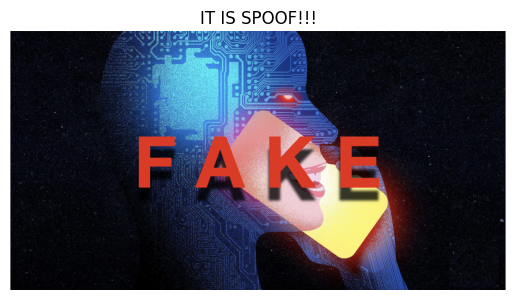

In [132]:
args = Args()

exp_setup = "I" if args.in_distribution else "O"
exp_name = f"{args.model_classname}_{args.feature_classname}_{exp_setup}"

root_save_dir = Path("saved")
save_dir = root_save_dir / exp_name
save_dir.mkdir(parents=True, exist_ok=True)
restore_path = save_dir / "best.pt"

ckpt = None
if args.restore and restore_path.is_file():
    ckpt = torch.load(restore_path, map_location=lambda storage, loc: storage)
    

if args.seed is not None:
    set_seed_all(args.seed)

if args.evaluation_one:
    eval_one(args.test_file, args.epochs, args.device, args.batch_size, args.feature_classname, args.model_classname, ckpt)
elif args.evaluation_only:
    eval_only(args.real_dir, args.fake_dir, args.epochs, args.device, args.batch_size, save_dir, args.feature_classname, args.model_classname, ckpt)   
else:
    args.display()
    train(args.real_dir, args.fake_dir, args.epochs, args.device, args.batch_size, save_dir, args.feature_classname, args.model_classname, args.in_distribution,ckpt)

real_dir: /home/dataset/data/real
fake_dir: /home/dataset/data/fake
test_file: /home/dataset/data/fake/ljspeech_parallel_wavegan/LJ001-0003_gen.wav
batch_size: 256
epochs: 20
seed: 42
feature_classname: lfcc
model_classname: SimpleLSTM
in_distribution: False
device: cuda
deterministic: False
evaluation_only: False
evaluation_one: False
restore: False
Loading data from /home/dataset/data/real...!
Loading data from /home/dataset/data/fake/ljspeech_melgan...!
Loading data from /home/dataset/data/fake/ljspeech_melgan_large...!
Loading data from /home/dataset/data/fake/ljspeech_full_band_melgan...!
Loading data from /home/dataset/data/fake/ljspeech_hifiGAN...!
Loading data from /home/dataset/data/fake/ljspeech_parallel_wavegan...!
Loading data from /home/dataset/data/fake/ljspeech_multi_band_melgan...!
Loading data from /home/dataset/data/fake/ljspeech_waveglow...!
[000]: loss: 0.1053 - train acc: 88.13 - val acc: 50.0
Best Validation Accuracy: 50.0
Best Model Saved: saved/SimpleLSTM_lfcc_O

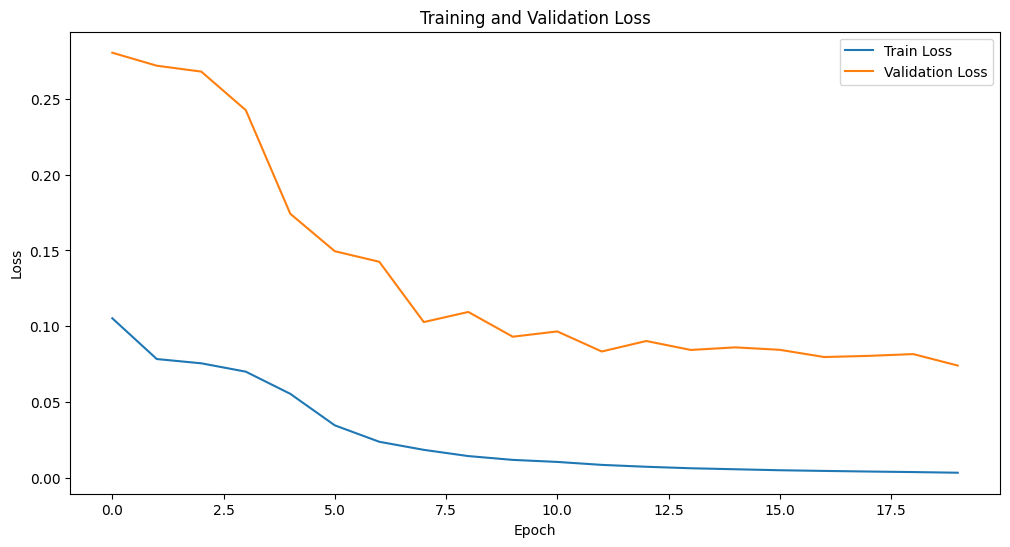

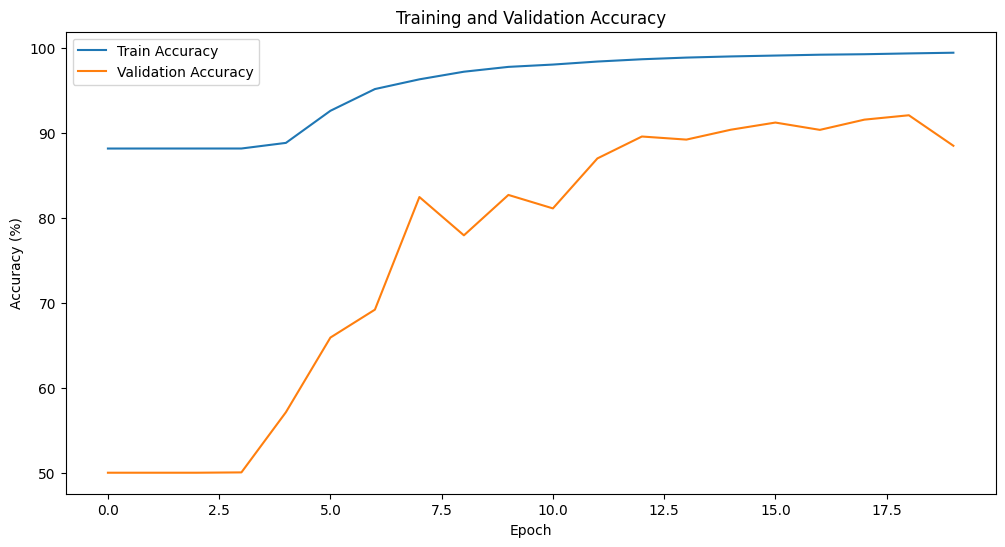

In [13]:
args = Args()

args.display()
exp_setup = "I" if args.in_distribution else "O"
exp_name = f"{args.model_classname}_{args.feature_classname}_{exp_setup}"
experiment(
    name=exp_name,
    test_file=args.test_file,
    real_dir=args.real_dir,
    fake_dir=args.fake_dir,
    epochs=args.epochs,
    batch_size=args.batch_size,
    feature_classname=args.feature_classname,
    model_classname=args.model_classname,
    in_distribution=args.in_distribution,
    device=args.device,
    seed=args.seed if args.deterministic else None,
    restore=args.restore,
    evaluation_only=args.evaluation_only,
    evaluation_one=args.evaluation_one,
)

### Citation 

*Dataset* 

https://keithito.com/LJ-Speech-Dataset/

https://arxiv.org/pdf/2111.02813.pdf

*Repository*

https://github.com/RUB-SysSec/WaveFake

https://github.com/MarkHershey/AudioDeepFakeDetection/tree/master/preprocess

*Additional References*

https://pytorch.org/docs/master/generated/torch.nn.LSTM.html#torch.nn.LSTM

